# GroupViT推理：零样本语义分割

你可能知道[CLIP](https://huggingface.co/docs/transformers/model_doc/clip)OpenAI的著名作品，以对比的方式对4亿对（图像、文本）进行训练，以匹配图像和文本。这样，通过简单地将图像分类作为将图像与适当文本配对的任务，该模型能够**零样本图像分类**（这意味着在不需要任何标签的情况下对图像进行分类）。

让我向您介绍一个新模型[GroupViT](https://twitter.com/xiaolonw/status/1501239921503129600)，这做了一些与CLIP非常相似的事情，但对于**零样本语义分割**的情况。语义分割是用特定类别（如“天空”、“人”等）标记图像的每个像素的任务。通常，在标记的数据集上训练模型（经典监督学习）。但是为语义分割创建标签是一项非常耗时的任务，因为人类需要用特定的类来注释图像的每个像素。

进入GroupViT：该模型类似于CLIP，在大量（图像、文本）对上进行训练，训练后，该模型能够识别图像中某些语义类别的组，只需将语义类别的名称链接到图像即可。

论文：https://arxiv.org/abs/2202.11094

🤗 文件：https://huggingface.co/docs/transformers/main/en/model_doc/groupvit

让我们用一个例子来说明这一点！


## 加载模型和处理器

在这里，我们从[HuggingFace Hub]加载模型和处理器(https://huggingface.co/). 请注意，NVIDIA已经发布了几个检查点，所有这些检查点都可以在[此处]找到(https://huggingface.co/models?other=groupvit). 一定要和他们一起玩！

我们还将加载处理器，该处理器可用于为模型准备图像和文本。

如果模型可用，我们将其移动到GPU。

In [1]:
from mindnlp.transformers import AutoProcessor, GroupViTModel

# load model + processor
model_name = "nvidia/groupvit-gcc-yfcc"
processor = AutoProcessor.from_pretrained(model_name)
model = GroupViTModel.from_pretrained(model_name)

# move to GPU

model

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.547 seconds.
Prefix dict has been built successfully.
/home/lmh/mindnlp/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(
Some weights of the model checkpoint at nvidia/groupvit-gcc-yfcc were not used when initializing GroupViTModel: ['text_model.embeddings.position_ids']
- This IS expected if you are initializing GroupViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GroupViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

GroupViTModel(
  (text_model): GroupViTTextTransformer(
    (embeddings): GroupViTTextEmbeddings(
      (token_embedding): Embedding(49408, 256)
      (position_embedding): Embedding(77, 256)
    )
    (encoder): GroupViTTextEncoder(
      (layers): ModuleList(
        (0-11): 12 x GroupViTEncoderLayer(
          (self_attn): GroupViTAttention(
            (k_proj): Linear (256 -> 256)
            (v_proj): Linear (256 -> 256)
            (q_proj): Linear (256 -> 256)
            (out_proj): Linear (256 -> 256)
          )
          (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GroupViTMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear (256 -> 1024)
            (fc2): Linear (1024 -> 256)
          )
          (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (final_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (vision_model): GroupViTVisionTr

## 准备图像

在这里，我们从ADE20k数据集中加载一张图像（实际上称为[MIT场景解析基准](http://sceneparsing.csail.mit.edu/))，是语义分割的重要基准。我们还加载了相应的地面真实分割图。

Using the latest cached version of the module from /home/lmh/.cache/huggingface/modules/datasets_modules/datasets/hf-internal-testing--fixtures_ade20k/dbb69c3ff2da9a2dcc2de41e8d7ab6543402914292e3d29a4f9701bef817e7db (last modified on Wed Oct  9 20:59:14 2024) since it couldn't be found locally at hf-internal-testing/fixtures_ade20k, or remotely on the Hugging Face Hub.


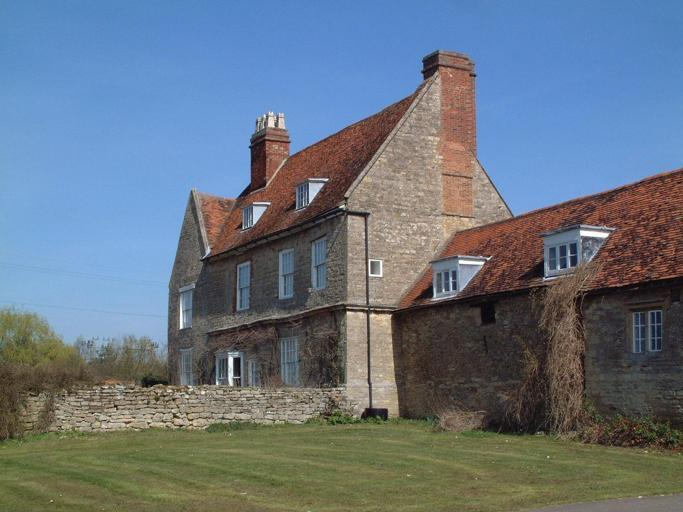

In [2]:
from datasets import load_dataset
from PIL import Image

# load image + ground truth map
ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test")
image = Image.open(ds[0]["file"])
display(image)
segmentation_map = Image.open(ds[1]["file"])
image = image.resize((224, 224))

GroupViT学习将语义类别与像素相匹配。

首先，我们将收集150个ADE20k类，模型可以找到与图像像素的匹配。

In [3]:
def ade_class():
    """ADE20K classes names."""
    return [
         'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed ',
        'windowpane', 'grass', 'cabinet', 'sidewalk', 'person', 'earth',
        'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car',
        'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug',
        'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe',
        'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column',
        'signboard', 'chest of drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path',
        'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door',
        'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffee table',
        'toilet', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove',
        'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar',
        'arcade machine', 'hovel', 'bus', 'towel', 'light', 'truck', 'tower',
        'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
        'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister',
        'escalator', 'ottoman', 'bottle', 'buffet', 'poster', 'stage', 'van',
        'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything',
        'swimming pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent',
        'bag', 'minibike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank',
        'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake',
        'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce',
        'vase', 'traffic light', 'tray', 'ashcan', 'fan', 'pier', 'crt screen',
        'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass',
        'clock', 'flag'
    ]

接下来，我们为模型准备图像和文本。我们基本上为模型创建150个图像-文本对。

In [4]:
inputs = processor(
    text=[f"a photo of a {word}" for word in ade_class()],
    images=image,
    return_tensors="ms",
    padding=True,
)

Unused or unrecognized kwargs: padding.


In [5]:
for k,v in inputs.items():
  print(k,v.shape)

input_ids (150, 9)
attention_mask (150, 9)
pixel_values (1, 3, 224, 224)


## 前向传播

接下来，让我们通过模型转发“像素值”和“input_ids”，以获得logits。

In [6]:
outputs = model(**inputs, output_segmentation=True)
logits = outputs.segmentation_logits

## 可视化

最后，让我们将模型预测的分割图可视化。语义分割数据集通常定义了所谓的“调色板”，它定义了每个类使用的RGB值。

ADE20k数据集由150个类组成，因此下面的列表有150个元素。

In [7]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

模型输出形状为“（batch_size，num_labels，height/4，width/4）”的logits。我们首先使用双线性插值重新缩放logits以匹配图像的原始大小。接下来，我们在类维度上执行argmax，并在图像上绘制一个颜色图。

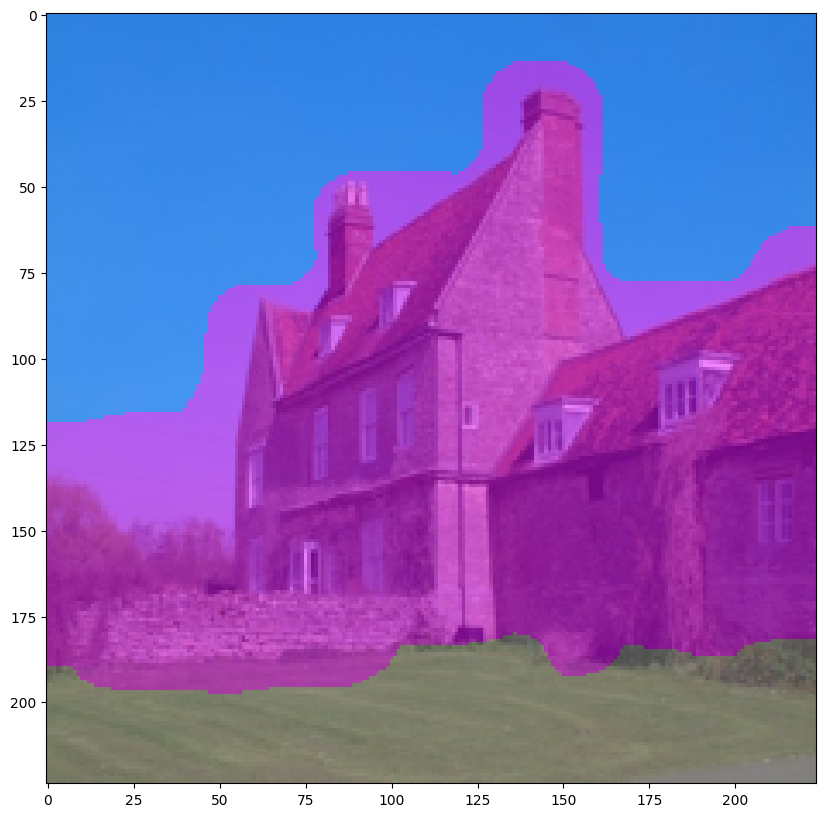

In [8]:
from mindnlp.core import nn, ops
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = ops.argmax(logits, dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[(seg == label).asnumpy(), :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

该模型能够做到这一点，而无需在人类注释的语义数据集上进行训练。

太神奇了，不是吗？它展示了语言在改进计算机视觉模型方面的潜力。